In [144]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/sparg")

import sparg
import importlib
importlib.reload(sparg)
import tskit
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("always")

In [145]:
ts = tskit.load("../../simulations/TwoPopsTwoDims/outputs/original/S025_I1_R2_W100_D2/rep1_S025_I1_R2_W100_D2.trees")

np.random.seed(4)
samples = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
ts_small, maps_small = sparg.simplify_with_recombination(ts=ts_sim, flag_recomb=True)
spatial_arg = sparg.SpatialARG(ts=ts_small, verbose=True)

/opt/anaconda3/envs/sparg/lib/python3.12/site-packages/sparg/__init__.py:142: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  recomb_nodes = ts.edges_parent[np.in1d(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents.


Prepared input parameters - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1940/1940 [00:01<00:00, 1024.35it/s]


Calculated covariance matrix - Section Elapsed Time: 1.9 - Total Elapsed Time: 1.9
Inverted covariance matrix - Section Elapsed Time: 0.2 - Total Elapsed Time: 2.11
Created root locations vector - Section Elapsed Time: 0.9 - Total Elapsed Time: 3.01
Estimated dispersal rate - Section Elapsed Time: 0.0 - Total Elapsed Time: 3.01
Calculated Fisher's information matrices - Section Elapsed Time: 0.0 - Total Elapsed Time: 3.01
Completed building SpatialARG object - Total Elapsed Time: 3.01


## Locating interesting recombination events

For this figure, we want a relatively centrally placed recombination about half way into the past (500 generations) that separates neighboring blocks are tracked to different ancestral subpopulations. These conditions create the classic "Y" shape where the blocks are together in the recent past before splitting to  

In [146]:
location_x = []
composition = []

subpop_and_seq_len = [[0 for subpop in range(2)] for s in ts_small.samples()]

for tree in ts_small.trees():
    for root in tree.roots:
        if ts_small.individual(ts_small.node(root).individual).location[0] < 50:
            subpop = 0
        else:
            subpop = 1
        for leaf in tree.samples(root):
            subpop_and_seq_len[leaf][subpop] += tree.span

for j,sample in enumerate(subpop_and_seq_len):
    location_x.append(ts_small.individual(ts_small.node(j).individual).location[0])
    comp_per = subpop_and_seq_len[j][1] / sum(subpop_and_seq_len[j])
    composition.append(comp_per)
    loc = ts_small.individual(ts_small.node(j).individual).location[0]
    if comp_per >= 0.4 and comp_per <= 0.6 and loc >= 40 and loc <= 60:
        sample_blocks = [[] for i in range(ts_small.num_samples)]
        ts_sample = ts_small.simplify(samples=[j], keep_input_roots=False, keep_unary=True, update_sample_flags=False)
        breakpoints = list(ts_sample.breakpoints())
        sample_blocks = []
        for tree in ts_sample.trees():
            for root in tree.roots:
                if ts_sample.individual(ts_sample.node(root).individual).location[0] < 50:
                    subpop = 0
                else:
                    subpop = 1
                for leaf in tree.samples(root):
                    sample_blocks.append(subpop)
        for i,block in enumerate(sample_blocks[:-1]):
            if block != sample_blocks[i+1]:
                tree_left = list(ts_sample.at((breakpoints[i]+breakpoints[i+1])/2).nodes())
                tree_right = list(ts_sample.at((breakpoints[i+1]+breakpoints[i+2])/2).nodes())
                for node in reversed(tree_left):
                    if node not in tree_right:
                        if ts_sample.node(node).time >= 250 and ts_sample.node(node).time <= 500:
                            print(j, breakpoints[i+1], (breakpoints[i]+breakpoints[i+1])/2, (breakpoints[i+1]+breakpoints[i+2])/2, ts_sample.node(node).time)
                        break
                

63 788699.0 710431.0 804871.5 412.0
66 314087.0 271444.5 362364.5 432.0
66 794848.0 782765.0 868002.5 405.0
96 314087.0 271444.5 393793.0 432.0
96 794848.0 782765.0 806929.0 405.0


In [147]:
sample = 63
bp_interest = 788699.0

locations_df = sparg.create_recombination_event_dataframe(
    ts=ts_sim,
    breakpoint=bp_interest,
    samples=[sample],
    include_locations=True
)

locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(df=locations_df, spatial_arg=spatial_arg)
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=-1, use_theoretical_dispersal=False)

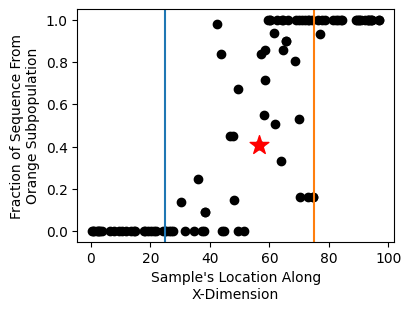

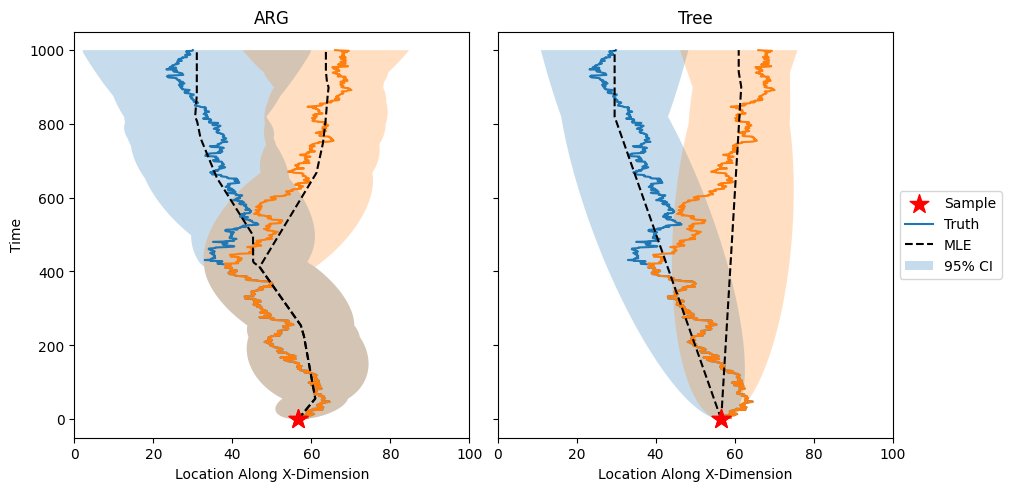

In [210]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, layout="constrained", sharey=True)

ax0.scatter(location_x, composition, color="black", alpha=1)
ax0.scatter(location_x[sample], composition[sample], color="red", s=200, marker="*")
ax0.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
ax0.axvline(x = 75, color = "#ff7f0e", label = "Starting Location of Orange Subpopulation")
ax0.set_xlabel("Sample's Location Along\nX-Dimension")
ax0.set_ylabel("Fraction of Sequence From\nOrange Subpopulation")

fig.set_figwidth(4)
fig.set_figheight(3)
plt.savefig("subfigures/Fig7_Comp.svg")
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, layout="constrained", sharey=True)

ax1.scatter(locations_df.loc[locations_df["time"]==0,"true_location_0"],locations_df.loc[locations_df["time"]==0,"time"], color="red", s=200, marker="*", zorder=3)
ax2.scatter(locations_df.loc[locations_df["time"]==0,"true_location_0"],locations_df.loc[locations_df["time"]==0,"time"], color="red", s=200, marker="*", zorder=3, label="Sample")

counter = 0
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        ax1.plot(region["true_location_0"], region["time"])
        if counter == 0:
            ax2.plot(region["true_location_0"], region["time"], label="Truth")
        else:
            ax2.plot(region["true_location_0"], region["time"])
        counter += 1

counter = 0
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["arg_estimated_location_0"]-1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
            right.append(row["arg_estimated_location_0"]+1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
        ax1.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25
        )
        ax1.plot(region["arg_estimated_location_0"], region["time"], color="black", linestyle="dashed")

        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_-1_estimated_location_0"]-1.96*math.sqrt(round(row["window_-1_variance_in_estimated_location_0"],3)))
            right.append(row["window_-1_estimated_location_0"]+1.96*math.sqrt(round(row["window_-1_variance_in_estimated_location_0"],3)))
        if counter == 0:
            ax2.plot(region["window_-1_estimated_location_0"], region["time"], color="black", linestyle="dashed", label="MLE")
            ax2.fill_betweenx(
                y=region["time"],
                x1=left,
                x2=right,
                alpha=0.25,
                label="95% CI"
            )
        else:
            ax2.fill_betweenx(
                y=region["time"],
                x1=left,
                x2=right,
                alpha=0.25
            )
            ax2.plot(region["window_-1_estimated_location_0"], region["time"], color="black", linestyle="dashed")
        counter += 1

ax1.set_title("ARG")
ax2.set_title("Tree")

ax1.set_xlabel("Location Along X-Dimension")
ax1.set_ylabel("Time")
ax2.set_xlabel("Location Along X-Dimension")

ax1.set_xlim(0,100)
ax2.set_xlim(0,100)

ax2.legend(bbox_to_anchor=(1, 0.625))

fig.set_figwidth(10)
plt.savefig("subfigures/Fig7_Tracking.svg")
plt.show()

In [141]:
locations_df = sparg.create_recombination_event_dataframe(
    ts=ts_sim,
    breakpoint=bp_interest,
    samples=[sample],
    include_locations=True
)

windows = [-1] + list(range(0,600,100))

print(windows)

for w in windows:
    locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=w, use_theoretical_dispersal=False)

[-1, 0, 100, 200, 300, 400, 500]


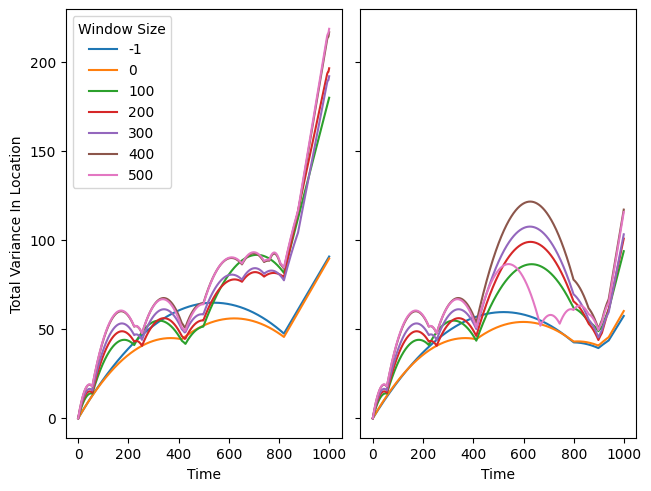

In [142]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, layout="constrained", sharey=True)

for w in windows:
    ax0.plot(locations_df.loc[locations_df["genome_position"]==788698.0,"time"], locations_df.loc[locations_df["genome_position"]==788698.0,f"window_{w}_variance_in_estimated_location_0"], label=w)
    ax1.plot(locations_df.loc[locations_df["genome_position"]==788700.0,"time"], locations_df.loc[locations_df["genome_position"]==788700.0,f"window_{w}_variance_in_estimated_location_0"])
ax0.legend(title="Window Size")
ax0.set_ylabel("Total Variance In Location")
ax0.set_xlabel("Time")
ax1.set_xlabel("Time")

plt.show()

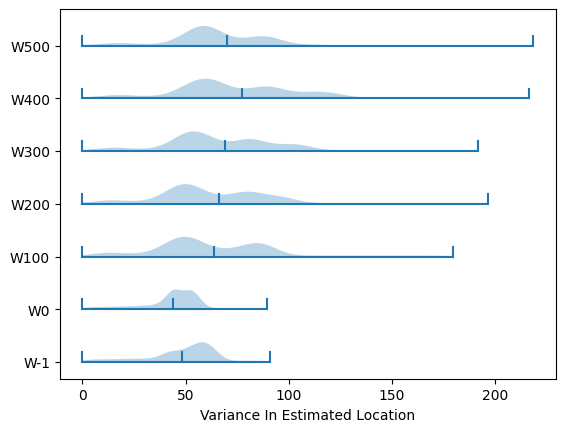

In [143]:
plt.violinplot([
    locations_df["window_-1_variance_in_estimated_location_0"],
    locations_df["window_0_variance_in_estimated_location_0"],
    locations_df["window_100_variance_in_estimated_location_0"],
    locations_df["window_200_variance_in_estimated_location_0"],
    locations_df["window_300_variance_in_estimated_location_0"],
    locations_df["window_400_variance_in_estimated_location_0"],
    locations_df["window_500_variance_in_estimated_location_0"]
], showmeans=True, vert=False, side="high", widths=0.75)
plt.yticks([1,2,3,4,5,6,7], ["W-1", "W0", "W100", "W200", "W300", "W400", "W500"])
plt.xlabel("Variance In Estimated Location")
plt.show()

## Using the full chromosome

In [12]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(df=locations_df, spatial_arg=spatial_arg)

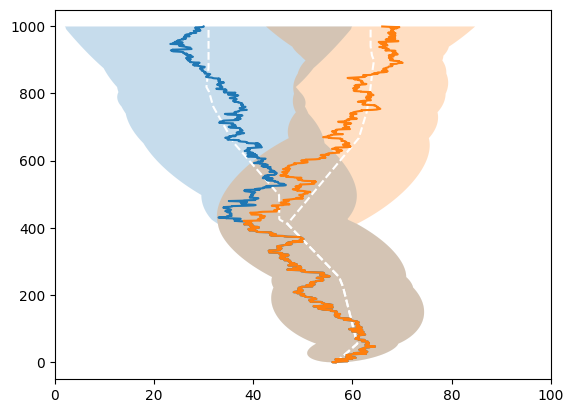

In [40]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["arg_estimated_location_0"]-1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
            right.append(row["arg_estimated_location_0"]+1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["arg_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")

for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        plt.plot(region["true_location_0"], region["time"])

plt.xlim(0,100)
plt.savefig("subfigures/Fig7_Tracking_Chrom.svg")
plt.show()

## Using an ARG with the two trees neighboring the breakpoint

In [14]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=0, use_theoretical_dispersal=False)

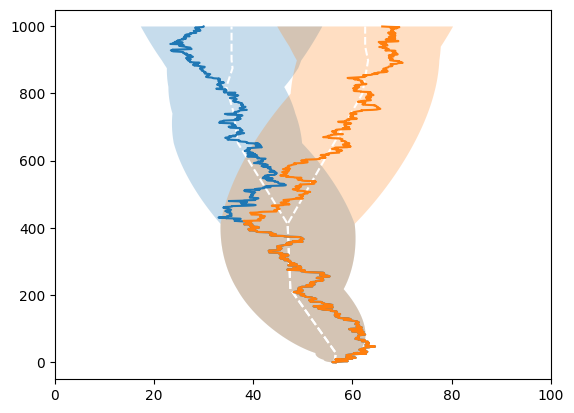

In [15]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_0_estimated_location_0"]-1.96*math.sqrt(round(row["window_0_variance_in_estimated_location_0"],3)))
            right.append(row["window_0_estimated_location_0"]+1.96*math.sqrt(round(row["window_0_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["window_0_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")

for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        plt.plot(region["true_location_0"], region["time"])

plt.xlim(0,100)
plt.savefig("subfigures/Fig7_Tracking_W0.svg")
plt.show()

## Using the two trees neighboring the breakpoint independently

This section estimates the locations of the lineage using only its local tree. The blue and orange lineages have different local trees, so they will have separate estimates for their locations, even below the recombination node when we know they should be together.

In [16]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=-1, use_theoretical_dispersal=False)

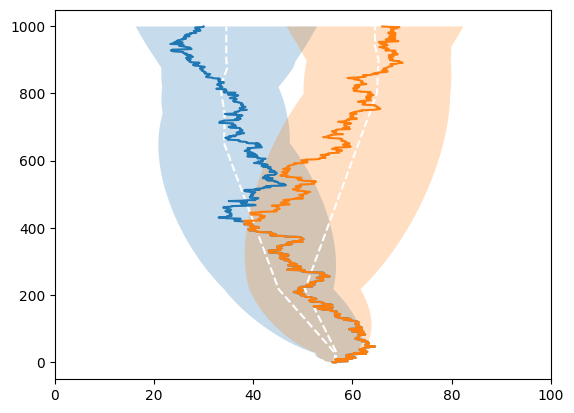

In [17]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_-1_estimated_location_0"]-1.96*math.sqrt(round(row["window_-1_variance_in_estimated_location_0"],3)))
            right.append(row["window_-1_estimated_location_0"]+1.96*math.sqrt(round(row["window_-1_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["window_-1_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")

for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        plt.plot(region["true_location_0"], region["time"])

plt.xlim(0,100)
plt.savefig("subfigures/Fig7_Tracking_W-1.svg")
plt.show()

## Using an ARG with window 100 (100 trees on either side of the breakpoint)

In [18]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=100, use_theoretical_dispersal=False)

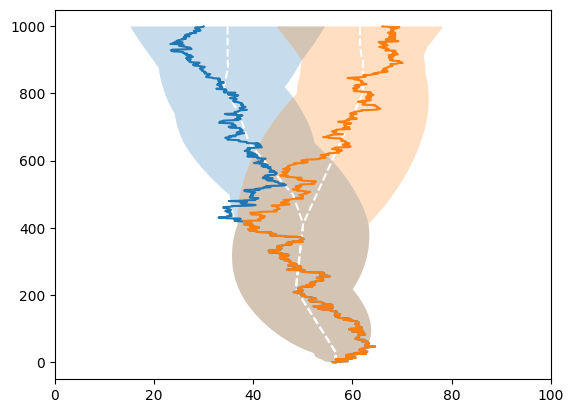

In [19]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_100_estimated_location_0"]-1.96*math.sqrt(round(row["window_100_variance_in_estimated_location_0"],3)))
            right.append(row["window_100_estimated_location_0"]+1.96*math.sqrt(round(row["window_100_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["window_100_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")

for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        plt.plot(region["true_location_0"], region["time"])

plt.xlim(0,100)
plt.savefig("subfigures/Fig7_Tracking_W100.svg")
plt.show()

## Comparing the variances between approaches

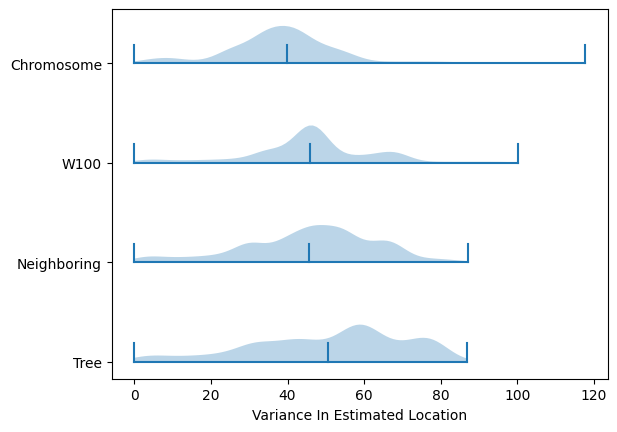

In [20]:
plt.violinplot([
    locations_df["window_-1_variance_in_estimated_location_0"],
    locations_df["window_0_variance_in_estimated_location_0"],
    locations_df["window_100_variance_in_estimated_location_0"],
    locations_df["arg_variance_in_estimated_location_0"],
], showmeans=True, vert=False, side="high", widths=0.75)
plt.yticks([1,2,3,4], ["Tree", "Neighboring", "W100", "Chromosome"])
plt.xlabel("Variance In Estimated Location")
plt.show()

## Genome Bar

This section may need to be removed unless I finalize the genome bar view in the `tskit_arg_visualizer`. I do think that this is a useful view to have so I wil work on this for our submission.

In [82]:
ts_sample = ts_small.simplify(samples=[63], keep_input_roots=False, keep_unary=True, update_sample_flags=False)
breakpoints = list(ts_sample.breakpoints())
block_colors = {}
i = 0
for tree in ts_sample.trees():
    for root in tree.roots:
        if ts_sample.individual(ts_sample.node(root).individual).location[0] < 50:
            subpop = "blue"
        else:
            subpop = "orange"
        for leaf in tree.samples(root):
            block_colors[i] = subpop
            i += 1

In [83]:
%%javascript
var script = document.createElement('script');
script.type = 'text/javascript';
script.src = 'https://d3js.org/d3.v7.min.js';
document.head.appendChild(script);

<IPython.core.display.Javascript object>

In [91]:
d3arg = tskit_arg_visualizer.D3ARG.from_ts(ts=ts_sample)
d3arg.set_breakpoint_fill(colors=block_colors)
d3arg.draw_genome_bar(windows=[[587371.0, 970014.0]])